In [23]:
# Uploading necessary libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, balanced_accuracy_score
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import statsmodels.api as sm

import pickle

In [24]:
# Load dataset "companies" divided on train and test sample.
# AFTER encoding categorical variables (e.g., one-hot encoding)

with open("outputs/df_companies_train_test_encoded.pkl", "rb") as f: # rb = read in a binary mode
   companies_train_encoded = pickle.load(f)
   companies_test_encoded = pickle.load(f)

df_companies_test_encoded.head() 

,revenue,netincome,r&d,sg&a,ebit,revenuegrowth,ebitmargin,netmargin,rd_to_revenue,sga_to_revenue,...,GS10,UMCSENT,negative_equity_flag,label_Cloud & Data,label_Collab & CX SaaS,label_Consumer SaaS,label_Enterprise SaaS,label_Mature Pivots,label_Mega‑Cap Tech,label_Vertical SaaS
346,5.859440e+08,-452551000.0,264041000.0,5.821620e+08,-462674000.0,0.510694,-0.789622,-0.772345,0.450625,0.993545,...,2.951667,58.975000,False,1,0,0,0,0,0,0
378,2.065659e+09,-797526000.0,788058000.0,1.402328e+09,-842267000.0,0.694098,-0.407747,-0.386088,0.381504,0.678877,...,2.951667,58.975000,False,1,0,0,0,0,0,0
293,8.743320e+08,-41459000.0,218523000.0,4.339510e+08,-27626000.0,0.134362,-0.031597,-0.047418,0.249931,0.496323,...,1.442500,77.616667,True,0,0,0,1,0,0,0
324,5.722210e+08,-43429000.0,185863000.0,2.528510e+08,-23836000.0,0.075242,-0.041655,-0.075896,0.324810,0.441876,...,2.951667,58.975000,False,0,0,0,0,0,0,1
179,8.360330e+08,242317000.0,166654000.0,3.463590e+08,144208000.0,0.264689,0.172491,0.289841,0.199339,0.414289,...,0.894167,81.541667,False,0,0,0,1,0,0,0


In [25]:
# definiujemuy macierz predyktorów X i kolumnę y
companies_train_X = df_companies_train_encoded.drop(columns=['revenuegrowth_t+1'])
companies_train_y = df_companies_train_encoded['revenuegrowth_t+1']

companies_test_X = df_companies_test_encoded.drop(columns=['revenuegrowth_t+1'])
companies_test_y = df_companies_test_encoded['revenuegrowth_t+1']

# definicja strategii walidacji krzyżowej
cv5x3 = RepeatedKFold(n_splits=5, 
                      n_repeats=3, 
                      random_state=123)

# inicjalizacja modelu
companies_reglin = LinearRegression()

In [26]:
# stosujemy walidację krzyżową za pomocą funkcji cross_val_score() do obliczenia wymaganych metryk
cv_r2 = cross_val_score(companies_reglin, 
                        companies_train_X, 
                        companies_train_y, 
                        cv = cv5x3, 
                        scoring = 'r2')

cv_rmse = np.sqrt(-cross_val_score(companies_reglin, 
                                   companies_train_X,
                                   companies_train_y, 
                                   cv = cv5x3, 
                                   scoring = 'neg_mean_squared_error'))

cv_mae = -cross_val_score(companies_reglin,
                          companies_train_X,
                          companies_train_y, 
                          cv = cv5x3, 
                          scoring = 'neg_mean_absolute_error')

cv_mape = -cross_val_score(companies_reglin, 
                           companies_train_X, 
                           companies_train_y, 
                           cv = cv5x3, 
                           scoring = 'neg_mean_absolute_percentage_error')

In [27]:
# szacujemy model na pełnych danych uczących

companies_reglin.fit(companies_train_X, companies_train_y)

# prognoza na danych testowych
y_test_pred = companies_reglin.predict(companies_test_X)

# metryki dla danych testowych
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

test_r2 = r2_score(companies_test_y, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(companies_test_y, y_test_pred))
test_mae = mean_absolute_error(companies_test_y, y_test_pred)
test_mape = mean_absolute_percentage_error(companies_test_y, y_test_pred)

In [28]:
# Wyświetlamy wyniki

# pamiętajmy, że cross_val_score() zwraca wartości dla wszystkich foldów
# - uśrednijmy je
print("Metryki w oparciu o walidację krzyżową:")
print(f"R2: {cv_r2.mean():.4f}")
print(f"RMSE: {cv_rmse.mean():.4f}")
print(f"MAE: {cv_mae.mean():.4f}")
print(f"MAPE: {cv_mape.mean():.4f}")

print("\nMetryki na danych testowych:")
print(f"R2: {test_r2:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"MAE: {test_mae:.4f}")
print(f"MAPE: {test_mape:.4f}")

# R2, RMSE i MAE w CV są niedoszacowane, natomiast MAPE jest przewidziane dość precyzyjnie

Metryki w oparciu o walidację krzyżową:
R2: 0.1253
RMSE: 0.2604
MAE: 0.1425
MAPE: 2.6456

Metryki na danych testowych:
R2: -47763.2660
RMSE: 51.4184
MAE: 5.2852
MAPE: 6.6380


In [29]:
# Load the selected variables list from pickle file
with open("outputs/companies_selected_vars.pkl", "rb") as f:
    companies_selected_vars = pickle.load(f)

# Find all label columns from the encoded DataFrame
label_cols = [col for col in df_companies_train_encoded.columns if col.startswith("label_")]

# Filter only numeric variables (i.e., exclude 'label')
filtered_vars = [
    var for var in companies_selected_vars
    if not var.startswith("label") and var != "label"
]

final_features = filtered_vars + label_cols

final_features

['revenuegrowth',
 'sga_to_revenue',
 'ebitmargin',
 'rd_to_revenue',
 'CPIAUCSL',
 'GDPC1',
 'liabilities',
 'label_Cloud & Data',
 'label_Collab & CX SaaS',
 'label_Consumer SaaS',
 'label_Enterprise SaaS',
 'label_Mature Pivots',
 'label_Mega‑Cap Tech',
 'label_Vertical SaaS']

In [30]:
# without labels witch choosen variables
# === Load Data ===
with open("outputs/df_companies_train_test_encoded.pkl", "rb") as f:
    df_companies_train_encoded = pickle.load(f)
    df_companies_test_encoded = pickle.load(f)

# === Define Target and Features ===
y = df_companies_train_encoded["revenuegrowth_t+1"]

# Drop target and categorical 'label_' columns
X = df_companies_train_encoded[filtered_vars]

# === Define Pipeline ===
poly_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(include_bias=False)),
    ("reg", LinearRegression())
])

# === Grid of Degrees ===
param_grid = {"poly__degree": [1, 2, 3, 4]}

# === Cross-Validation Strategy ===
cv5 = KFold(n_splits=5, shuffle=True, random_state=42)

# === Scoring Metrics ===
metrics = {
    "RMSE": "neg_root_mean_squared_error",
    "R2": "r2",
    "MAE": "neg_mean_absolute_error",
    "MAPE": "neg_mean_absolute_percentage_error"
}

# === Run GridSearch for Each Metric ===
results = {}

for name, scoring in metrics.items():
    grid_search = GridSearchCV(poly_pipeline, param_grid, cv=cv5, scoring=scoring, n_jobs=-1)
    grid_search.fit(X, y)
    results[name] = {
        "Best Degree": grid_search.best_params_["poly__degree"],
        "Best Score": grid_search.best_score_
    }

# === Display Results ===
results_df = pd.DataFrame(results).T
print("Polynomial Model Validation Results:")
print(results_df)


Polynomial Model Validation Results:
      Best Degree  Best Score
RMSE          1.0   -0.229595
R2            1.0    0.332690
MAE           1.0   -0.121311
MAPE          1.0   -1.594450


In [31]:
# with labels

# === Define Target and Features ===
y = df_companies_train_encoded["revenuegrowth_t+1"]

# Drop target and categorical 'label_' columns
X = df_companies_train_encoded[final_features]

# === Define Pipeline ===
poly_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(include_bias=False)),
    ("reg", LinearRegression())
])

# === Grid of Degrees ===
param_grid = {"poly__degree": [1, 2, 3, 4]}

# === Cross-Validation Strategy ===
cv5 = KFold(n_splits=5, shuffle=True, random_state=42)

# === Scoring Metrics ===
metrics = {
    "RMSE": "neg_root_mean_squared_error",
    "R2": "r2",
    "MAE": "neg_mean_absolute_error",
    "MAPE": "neg_mean_absolute_percentage_error"
}

# === Run GridSearch for Each Metric ===
results = {}
grid_searches = {}   

for name, scoring in metrics.items():
    grid_search = GridSearchCV(poly_pipeline, param_grid, cv=cv5, scoring=scoring, n_jobs=-1)
    grid_search.fit(X, y)
    results[name] = {
        "Best Degree": grid_search.best_params_["poly__degree"],
        "Best Score": grid_search.best_score_
    }

    grid_searches[name] = grid_search   

# === Display Results ===
results_df = pd.DataFrame(results).T
print("Polynomial Model Validation Results:")
print(results_df)


Polynomial Model Validation Results:
      Best Degree  Best Score
RMSE          1.0   -0.229005
R2            1.0    0.335955
MAE           1.0   -0.125328
MAPE          1.0   -1.733049


In [32]:
# grid_searches["R2"].cv_results_

In [33]:
rmse_results = pd.DataFrame(grid_searches["RMSE"].cv_results_)
print(rmse_results[["param_poly__degree", "mean_test_score", "std_test_score"]])

   param_poly__degree  mean_test_score  std_test_score
0                   1        -0.229005        0.071769
1                   2        -0.311494        0.050913
2                   3      -217.989311      302.663791
3                   4       -14.865732       24.926950


In [34]:
# === Get Best Model Based on RMSE ===
best_model_rmse = grid_searches["RMSE"].best_estimator_

# === Prepare Test Features ===
X_test = df_companies_test_encoded[final_features]

# === Predict ===
y_pred_test = best_model_rmse.predict(X_test)

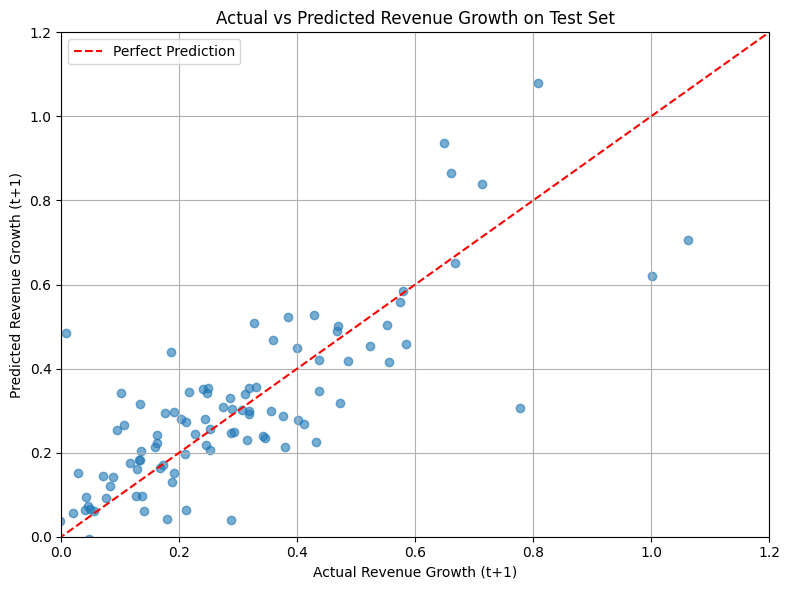

In [35]:
# === True target values ===
y_test = df_companies_test_encoded["revenuegrowth_t+1"]

# === Predicted values using best RMSE model ===
y_pred_test = best_model_rmse.predict(X_test)

# === Scatter Plot: Actual vs Predicted ===
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_test, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Prediction")
plt.xlabel("Actual Revenue Growth (t+1)")
plt.ylabel("Predicted Revenue Growth (t+1)")
plt.title("Actual vs Predicted Revenue Growth on Test Set")

# === Zoom in: adjust limits to exclude extreme outlier ===
plt.xlim(0, 1.2)
plt.ylim(0, 1.2)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
# === True and predicted values ===
y_true = df_companies_test_encoded["revenuegrowth_t+1"]
y_pred = best_model_rmse.predict(X_test)

# === Calculate metrics ===
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# === Display ===
print(f"Test RMSE:  {rmse:.4f}")
print(f"Test MAE:   {mae:.4f}")
print(f"Test MAPE:  {mape:.4f}")
print(f"Test R²:    {r2:.4f}")

Test RMSE:  56.4224
Test MAE:   5.7650
Test MAPE:  5.7463
Test R²:    -57512.3587


In [37]:
# ONLY FOR REFERENCE: with all the variables
# === Define Target and Features ===
y = df_companies_train_encoded["revenuegrowth_t+1"]

# Drop target and categorical 'label_' columns
X = df_companies_train_encoded.drop(columns=["revenuegrowth_t+1"]).select_dtypes(include="number")

# === Define Pipeline ===
poly_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("poly", PolynomialFeatures(include_bias=False)),
    ("reg", LinearRegression())
])

# === Grid of Degrees ===
param_grid = {"poly__degree": [1, 2, 3, 4]}

# === Cross-Validation Strategy ===
cv5 = KFold(n_splits=5, shuffle=True, random_state=42)

# === Scoring Metrics ===
metrics = {
    "RMSE": "neg_root_mean_squared_error",
    "R2": "r2",
    "MAE": "neg_mean_absolute_error",
    "MAPE": "neg_mean_absolute_percentage_error"
}

# === Run GridSearch for Each Metric ===
results = {}

for name, scoring in metrics.items():
    grid_search = GridSearchCV(poly_pipeline, param_grid, cv=cv5, scoring=scoring, n_jobs=-1)
    grid_search.fit(X, y)
    results[name] = {
        "Best Degree": grid_search.best_params_["poly__degree"],
        "Best Score": grid_search.best_score_
    }

# === Display Results ===
results_df = pd.DataFrame(results).T
print("Polynomial Model Validation Results:")
print(results_df)

Polynomial Model Validation Results:
      Best Degree  Best Score
RMSE          1.0   -0.290441
R2            1.0   -0.212444
MAE           1.0   -0.148945
MAPE          1.0   -2.305983
